# Minimal exchange sets
I recieved code from my supervisor, which calculates mps and mcs from the *Escherichia coli* (*E. coli*) core SBML model. We will eventually use the calculated mps to compare with ecms.

## Enumeration of minimal exchange reactions

In [1]:
# Importing libraries
import cobra
import matplotlib.pyplot as plt
import mptool as mpt
import numpy as np
import pandas as pd
import seaborn as sns
import csv

from collections import defaultdict
from itertools import product

# Constants
model_name = 'e_coli_core'
VISUALIZATION = False  # Set True if plots should be rendered

%matplotlib inline
sns.set(font_scale=1.5, style='ticks')

In [5]:
help(mpt.make_irreversible)

Help on function make_irreversible in module mptool:

make_irreversible(model, subset=set())
    Makes reactions in subset of model positive and irreversible.
    
    Args:
        model: COBRA or Gurobi model.
        subset: Iterable containing reactions to make irreversible or their IDs
                (if empty, all reactions in model are made irreversible).
    
    Returns:
        Subset with irreversible reactions.



In [2]:
# Load model
model = cobra.io.read_sbml_model('models/{}.xml'.format(model_name))
model

Restricted license - for non-production use only - expires 2023-10-25


<Model e_coli_core at 0x291e07c32e0>

In [3]:
# H. Pylori grown on medium "Min II", which is the same as "Min I", but with glucose
# model.reactions.EX_glc__D_e.bounds = (-1000, 1000)

# Check boundary conditions of model
for r in model.boundary:
    print(r, r.bounds)

EX_ac_e: ac_e -->  (0.0, 1000.0)
EX_acald_e: acald_e -->  (0.0, 1000.0)
EX_akg_e: akg_e -->  (0.0, 1000.0)
EX_co2_e: co2_e <=>  (-1000.0, 1000.0)
EX_etoh_e: etoh_e -->  (0.0, 1000.0)
EX_for_e: for_e -->  (0.0, 1000.0)
EX_fru_e: fru_e -->  (0.0, 1000.0)
EX_fum_e: fum_e -->  (0.0, 1000.0)
EX_glc__D_e: glc__D_e <=>  (-10.0, 1000.0)
EX_gln__L_e: gln__L_e -->  (0.0, 1000.0)
EX_glu__L_e: glu__L_e -->  (0.0, 1000.0)
EX_h_e: h_e <=>  (-1000.0, 1000.0)
EX_h2o_e: h2o_e <=>  (-1000.0, 1000.0)
EX_lac__D_e: lac__D_e -->  (0.0, 1000.0)
EX_mal__L_e: mal__L_e -->  (0.0, 1000.0)
EX_nh4_e: nh4_e <=>  (-1000.0, 1000.0)
EX_o2_e: o2_e <=>  (-1000.0, 1000.0)
EX_pi_e: pi_e <=>  (-1000.0, 1000.0)
EX_pyr_e: pyr_e -->  (0.0, 1000.0)
EX_succ_e: succ_e -->  (0.0, 1000.0)


The boundries infer whether the metabolite can be consumed or produced in the reactions in the network. (I think)
In the next cell, further boundries and objectives are set. Optimal solution is calculated. If I remember correctly, the negative fluxes indicate that the cell takes up the select metabolite. This means that the positive fluxes indicate production.

In [4]:
# Set growth and maintanance requirements and check viability for H. pylori
# model.reactions.BIOMASS_HP_published.lower_bound = 0.1

# Constraints for e_coli_core
model.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = 0.1
model.reactions.ATPM.lower_bound = 0

model.optimize()

<Solution 0.917 at 0x291ff74ff10>

In the next code chunks, we find the actual mps and mcs. Start by subsetting the exchange reactions, and use this subset to calculate mps.

In [8]:
# Define exchange reactions as subset for finding MPs
subset = list(r.id for r in model.exchanges)

# Split reactions beforehand: 
subset_irreversible = mpt.make_irreversible(model = model, subset = subset)
subset_irreversible = list(r.id for r in subset_irreversible)
print(subset_irreversible)

['EX_succ_e', 'EX_h2o_e_rev', 'EX_co2_e', 'EX_glc__D_e_rev', 'EX_pi_e', 'EX_fum_e', 'EX_akg_e', 'EX_etoh_e', 'EX_for_e', 'EX_nh4_e', 'EX_glc__D_e', 'EX_nh4_e_rev', 'EX_acald_e', 'EX_o2_e', 'EX_pi_e_rev', 'EX_h2o_e', 'EX_fru_e', 'EX_glu__L_e', 'EX_gln__L_e', 'EX_mal__L_e', 'EX_ac_e', 'EX_h_e_rev', 'EX_co2_e_rev', 'EX_pyr_e', 'EX_h_e', 'EX_lac__D_e', 'EX_o2_e_rev']


In [6]:
# Enumerate minimal sets of exchange reactions
mps, mcs, complete = mpt.find_mps(
    model,
    subset=set(subset_irreversible),
    method='iterative',
    graph=True,
    random=False,
    bounds={},
    tol=1e-09,
    inf=1000,
    threads=0,
    max_mps=0,
    max_t=0,
    verbose=True,
    export=True,
)

e_coli_core
Network size: 102
Subset size: 27

Flux variability analysis...
0 PFK (0.0, 166.07236999999992)
1 PFL (0.0, 37.44297000000019)
2 PGI (-45.460950000000025, 9.97950000000003)
3 PGK (-19.73417, -1.2540199999999686)
4 PGL (0.0, 55.44044999999998)
5 ACALD (-18.48015, 0.0)
6 AKGt2r (-9.240075000000001, 0.0)
7 PGM (-19.584569999999985, -1.1044200000000002)
8 PIt2r (0.3678699999999999, 3.3720710249009844)
9 ALCD2x (-18.48014999999998, 0.0)
10 ACALDt (-18.48014999999998, 0.0)
11 ACKr (-18.480150000000002, 0.0)
12 PPC (0.0, 156.4584)
13 ACONTa (0.10788999999999999, 18.588039999999978)
14 ACONTb (0.1078899999999976, 18.588039999999978)
15 ATPM (0.0, 156.17183999999992)
16 PPCK (0.0, 156.17183999999995)
17 ACt2r (-18.480150000000002, 0.0)
18 PPS (0.0, 156.17183999999986)
19 ADK1 (0.0, 156.17183999999986)
20 AKGDH (0.0, 18.48015)
21 ATPS4r (-31.55332, 138.4786325)
22 PTAr (0.0, 18.480150000000002)
23 PYK (0.0, 165.70449999999985)
24 BIOMASS_Ecoli_core_w_GAM (0.1, 0.9166474637510486)
25 

In [11]:
# Extract names of exchange reactions, but get rid of reaction suffix
subset_names = list(r.name for r in model.exchanges)
subset_names = list(name.replace(' exchange', '') for name in subset_names)

# Make a dictionary of sensible names for plotting later
sensible_names = {}
for metab, ids in zip(range(len(subset)), subset):
    sensible_names[ids] = subset_names[metab]

# Add names for IDs with '_rev' suffix and change 'Ammonia' to 'Ammonium':
for ID in sensible_names:
    if ID.endswith('_rev'):
        sensible_names[ID] = '{} rev'.format(sensible_names[ID.replace('_rev', '')])

sensible_names['EX_nh4_e'] = 'Ammonium'
sensible_names['EX_nh4_e_rev'] = 'Ammonium rev'

# Write to dictionary to file
file = open("{}_metabnames_mps.csv".format(model_name), "w")
writer = csv.writer(file)
for key, value in sensible_names.items():
    writer.writerow([key, value])
file.close()

In the end of the run, we can find both runtime of enumeration and the number of mcs and mps obtained. The network size of `e_coli_core.xml` is 95, which means there are 95 reactions in this model. Before enumeration, 20 reactions were subsetted (see object `subset`). Enumeration of minimal sets of exchange reactions for *E. coli* core model were found: 33 MPs, containing 18 reactions, and 14 MCs, also containing 18 reactions.

## Visualization
In this section two clustured heatmaps are presented. One visualizing which metabolites are included in the different mps, the other checking correlation between the occuring metabolites across mps.

<Figure size 432x288 with 0 Axes>

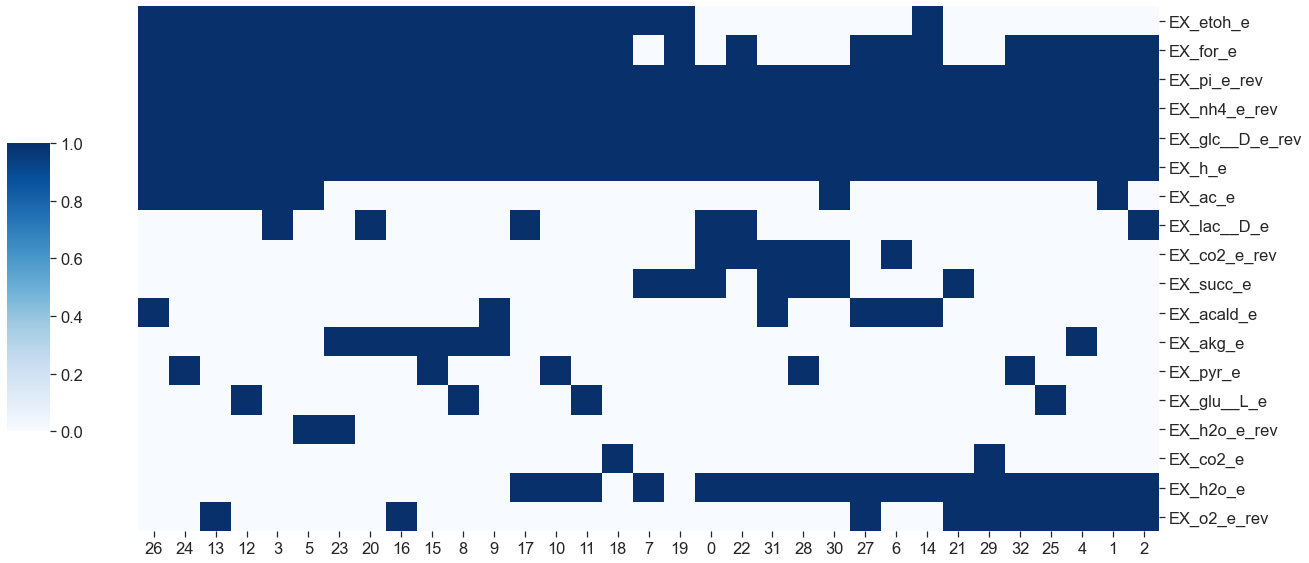

In [56]:
if VISUALIZATION:
    # Visualize MPs
    df = pd.DataFrame({i: {x: 1 for x in mp} for i, mp in enumerate(mps)}).fillna(0)
    
    # Metabolites present in each MP
    f = plt.figure()
    g = sns.clustermap(df, col_cluster=True, cmap='Blues', xticklabels=1, yticklabels=1, figsize=(20, 10))
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    g.fig.subplots_adjust(right=0.9)
    g.ax_cbar.set_position((0.1, .2, .03, .4))

In [57]:
if VISUALIZATION:
    # Count number of times reactions (exchanged metabolites) occur together in MPs
    d = defaultdict(dict)
    for mp in mps:
        for x1, x2 in product(mp, repeat=2):
            try:
                d[x1][x2] += 1
            except KeyError:
                d[x1][x2] = 1
    df = pd.DataFrame(d).fillna(0)
    df = df / len(mps) # Convert counts to fractions
    
    # Cluster reactions (exchanged metabolites) by co-occurence
    g = sns.clustermap(df, cmap='Blues', xticklabels=1, yticklabels=1)
    g.ax_col_dendrogram.set_visible(False)
    g.ax_row_dendrogram.set_visible(False)
    g.fig.subplots_adjust(right=1)
    g.ax_cbar.set_position((0.1, 0.3, 0.03, 0.4))

## Comparing MPs to ECMs

In [ ]:
# Sammenligne metabolitter som inngår i begge metodene
# Fordeling av metabolitter i hver ecm contra hver mptool
# Sammenligne antall ecms og mps
# Hvor lik er en enkelt mp til en ecm? - Hvordan sammenligne to sett?